<a href="https://colab.research.google.com/github/tnc-br/ddf-isoscapes/blob/main/dnn/variational_with_real_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DNN regressors

A variational model to find the mean/variance of O18 ratios at a particular lat/lon in the Brazilian Amazon. At the bottom of the colab, there are utilities to generate isoscapes from this model.

In [66]:
from collections import defaultdict
import math
import numpy as np
import pandas as pd
from typing import List

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from matplotlib import pyplot as plt
from tensorflow.python.ops import math_ops

#@title Debugging
# See https://zohaib.me/debugging-in-google-collab-notebook/ for tips,
# as well as docs for pdb and ipdb.
DEBUG = False #@param {type:"boolean"}
GDRIVE_BASE = "/content/drive" #@param
DATAFRAME_PATH = "/MyDrive/amazon_rainforest_files/2023_06_23_Results_Google_no_ol.csv" #@param
RASTER_BASE = "/MyDrive/amazon_rainforest_files/amazon_rasters/" #@param
MODEL_SAVE_LOCATION = "/MyDrive/amazon_rainforest_files/" #@param
OUTPUT_RASTER_BASE = "/MyDrive/amazon_rainforest_files/" #@param

def get_dataframe_path_from_params() -> str:
  root = GDRIVE_BASE if GDRIVE_BASE else ""
  return f"{root}{DATAFRAME_PATH}"

def get_model_save_location(filename) -> str:
  root = GDRIVE_BASE if GDRIVE_BASE else ""
  return f"{root}{MODEL_SAVE_LOCATION}{filename}"

def get_raster_path_from_params(filename) -> str:
  root = GDRIVE_BASE if GDRIVE_BASE else ""
  return f"{root}{RASTER_BASE}{filename}"

def get_output_raster_path_from_params(filename) -> str:
    root = GDRIVE_BASE if GDRIVE_BASE else ""
    return f"{root}{OUTPUT_RASTER_BASE}{filename}"


In [57]:
# Access data stored on Google Drive
if GDRIVE_BASE:
    from google.colab import drive
    drive.mount(GDRIVE_BASE)

if DEBUG:
    %pip install -Uqq ipdb
    import ipdb
    %pdb on

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
def render_plot_loss(history, name):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(name + ' model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['loss', 'val_loss'], loc='upper left')
  plt.show()

#Data preparation


In [80]:
from sklearn.model_selection import train_test_split

df = pd.read_csv(get_dataframe_path_from_params(), encoding="ISO-8859-1", sep=',')
df.drop(['Cod Lab', 'Species', 'd18O_cel_analysis', 'State', 'Origin', 'd15N_wood', '%N_wood', 'd13C_wood',
         '%C_wood', 'd13C_cel', '%C_cel', 'brisoscape_mean_ISORIX', 'Point', 'd18O_cel_CENA', 'ID', 'd18O_cel_Davis',
         'predkrig_br_lat_ISORG', 'PET', 'DEM', 'PA', 'Mean Annual Precipitation',
         'Iso_Oxi_Stack_mean_TERZER', 'isoscape_fullmodel_d18O_prec_REGRESSION'],
        axis = 1, inplace = True)
df = df[df['d18O_cel'].notna()]

grouped = df.groupby('Code')

# # ASSUMPTION: Taking the mean and variance of a sample site doesn't lower quality of the data.
# # We need to do this to use KL-divergence loss.
means = grouped.mean()
O18_var = grouped.var()['d18O_cel']

# Merging results in some unreadable column names. Rename the oxygen columns.
merged = pd.merge(means, O18_var, on=['Code'], how='inner').reset_index()
merged = merged.rename(columns={
    'd18O_cel_x': 'O18_mean',
    'd18O_cel_y': 'O18_var'})

# Some trees only got sampled at one point, and we can't calculate variance
# with one point. Drop these rows.
merged = merged.drop('Code', axis=1)
merged = merged[merged['O18_var'].notna()]

# Normalize by max value in the columns.
to_normalize = ['lat', 'long', 'VPD', 'RH', 'Mean Annual Temperature']
normalization_factors = {column: df[column].abs().max() for column in to_normalize}

def normalize(df, normalization_factors):
  for column, factor in normalization_factors.items():
    df[column] = df[column] / factor
  return df

merged = normalize(merged, normalization_factors)

train, test = train_test_split(merged, test_size=0.1, random_state=25)
Y_train_vars = train[["O18_mean", "O18_var"]]
Y_test_vars = test[["O18_mean", "O18_var"]]

# Features: Everything besides mean and variance
X_train_vars = train.drop(["O18_mean", "O18_var"], axis=1)
X_test_vars = test.drop(["O18_mean", "O18_var"], axis=1)


<ipython-input-80-345d4b62cbd0>:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = grouped.mean()
<ipython-input-80-345d4b62cbd0>:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  O18_var = grouped.var()['d18O_cel']


# Model Definition



The KL Loss function:

In [71]:
# log(σ2/σ1) + ( σ1^2+(μ1−μ2)^2 ) / 2* σ2^2   − 1/2
def kl_divergence(real, predicted):
    real_value = tf.gather(real, [0], axis=1)
    real_std = tf.math.sqrt(tf.gather(real, [1], axis=1))

    predicted_value = tf.gather(predicted, [0], axis=1)
    predicted_std = tf.math.sqrt(tf.gather(predicted, [1], axis=1))

    kl_loss = -0.5 + tf.math.log(predicted_std/real_std) + \
     (tf.square(real_std) + tf.square(real_value - predicted_value))/ \
     (2*tf.square(predicted_std))

    return tf.math.reduce_mean(kl_loss)

def symmetric_kl(real, predicted):
  return kl_divergence(real, predicted) + kl_divergence(predicted, real)

Test the loss function:

In [72]:
import pytest

test_real = tf.convert_to_tensor(np.array([[1, 0.02]]))
test_pred = tf.convert_to_tensor(np.array([[0.98, 0.021]]))

# https://screenshot.googleplex.com/5WM9dinAbhR26ZS
assert float(kl_divergence(test_real, test_pred)) == pytest.approx(0.0101094, 1e-5)

test_neg_real = tf.convert_to_tensor(np.array([[32.32, 0.0344]]))
test_neg_pred = tf.convert_to_tensor(np.array([[32.01, -0.322]]))

# Negative variance causes NaN
assert tf.math.is_nan(kl_divergence(test_neg_real, test_neg_pred))

test_real_2d = tf.convert_to_tensor(np.array(
    [[1.00, 0.020],
     [1.01, 0.042]]))
test_pred_2d = tf.convert_to_tensor(np.array(
    [[0.98, 0.021],
     [0.99, 0.012]]))

# Should reduce to the average loss of all rows.
assert float(kl_divergence(test_real_2d, test_pred_2d)) == pytest.approx(
    sum([0.0101094, 0.6402851])/2, 1e-5)

Model definition

In [81]:
from keras.callbacks import ModelCheckpoint

early_stop = keras.callbacks.EarlyStopping(
    monitor='loss', patience=1000, min_delta=0.001, verbose=1,
    restore_best_weights=True, start_from_epoch=0)

# I was experimenting with models that took longer to train, and used this
# checkpointing callback to periodically save the model. It's optional.
def get_checkpoint_callback(model_file):
  return ModelCheckpoint(
      get_model_save_location(model_file),
      monitor='loss', verbose=1, save_best_only=True, mode='min')

def train_vars(X: pd.DataFrame,
        Y: pd.DataFrame,
        hidden_layers: List[int],
        epochs: int,
        batch_size: int,
        lr: float,
        model_file=None,
        use_checkpoint=False):
  callbacks_list = [early_stop, get_checkpoint_callback(model_file)]
  if not use_checkpoint:
    inputs = keras.Input(shape=(X.shape[1],))
    x = inputs
    for layer_size in hidden_layers:
      x = keras.layers.Dense(
          layer_size, activation='relu')(x)
    mean_output = keras.layers.Dense(1, name='mean_output')(x)

    # We can not have negative variance. Apply very little variance.
    var_output = keras.layers.Dense(1, name='var_output',
                                    kernel_regularizer=keras.regularizers.L2(0.00001))(x)
    abs_var = keras.layers.Lambda(lambda t: tf.abs(t))(var_output)

    # Output mean, |variance| tuples.
    outputs = keras.layers.concatenate([mean_output, abs_var])
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Later epochs seem to benefit from lower learning rate... but it takes
    # a while to get there.
    decay = keras.optimizers.schedules.ExponentialDecay(
       lr, decay_steps=1000, decay_rate=0.5, staircase=False)

    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=symmetric_kl)
    model.summary()
  else:
    model = keras.models.load_model(get_model_save_location(model_file),
                                    custom_objects={"symmetric_kl": symmetric_kl})
  history = model.fit(X, Y, verbose=1, epochs=epochs, batch_size=batch_size,
            validation_split=0.2, shuffle=True, callbacks=callbacks_list)
  return history, model

Streaming output truncated to the last 5000 lines.
Epoch 751/2000
1/9 [==>...........................] - ETA: 0s - loss: 4.2285
Epoch 751: loss did not improve from 5.55639
9/9 [==============================] - 0s 11ms/step - loss: 5.8784 - val_loss: 3.5345
Epoch 752/2000
1/9 [==>...........................] - ETA: 0s - loss: 4.4287
Epoch 752: loss did not improve from 5.55639
9/9 [==============================] - 0s 12ms/step - loss: 5.5952 - val_loss: 3.5183
Epoch 753/2000
1/9 [==>...........................] - ETA: 0s - loss: 4.0732
Epoch 753: loss did not improve from 5.55639
9/9 [==============================] - 0s 9ms/step - loss: 5.9992 - val_loss: 3.2637
Epoch 754/2000
1/9 [==>...........................] - ETA: 0s - loss: 2.4210
Epoch 754: loss did not improve from 5.55639
9/9 [==============================] - 0s 11ms/step - loss: 5.6469 - val_loss: 3.5416
Epoch 755/2000
1/9 [==>...........................] - ETA: 0s - loss: 2.3264
Epoch 755: loss did not improve from 5.55

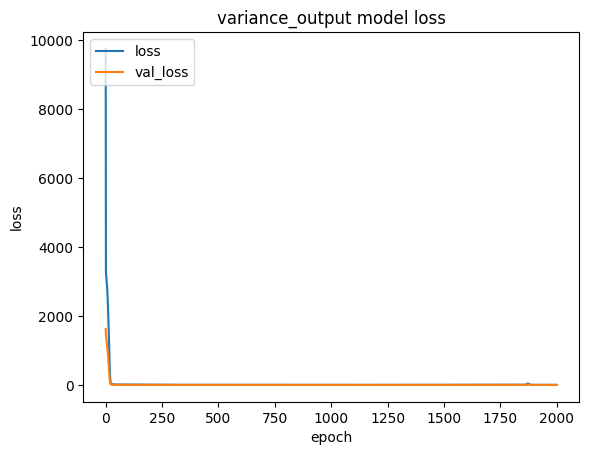

In [82]:
history, vars_model = train_vars(X_train_vars, Y_train_vars, hidden_layers=[200, 200],
                                 epochs=2000, batch_size=10, lr=0.001,
                                 model_file="variational_ucd_yearly_simple_no_ol.h5", use_checkpoint=False)
render_plot_loss(history, "variance_output")

In [83]:
vars_model = keras.models.load_model(
    get_model_save_location("variational_ucd_yearly_simple_no_ol.h5"),
    custom_objects={"symmetric_kl": symmetric_kl})

vars_model.evaluate(x=X_test_vars, y=Y_test_vars)
predictions = vars_model.predict_on_batch(X_test_vars)
print(X_test_vars[:1])
print("EXPECTED:")
print(Y_test_vars[:12])
print()
print("PREDICTED:")
print(pd.DataFrame(predictions, columns=['O18_mean', 'O18_var'])[:12])

1/1 [==============================] - 0s 172ms/step - loss: 2.9250
         lat  long       VPD        RH  Mean Annual Temperature
21 -0.328996  -1.0  0.742011  0.958431                 0.979626
EXPECTED:
     O18_mean  O18_var
21     23.768  0.04842
41     26.062  1.11127
80     23.442  1.57727
34     25.912  0.47897
33     25.076  0.23028
27     24.608  1.65047
79     26.532  2.73152
6      26.884  0.36018
114    24.656  0.17728
20     25.006  0.27213
113    26.984  0.40123
71     26.202  0.11327

PREDICTED:
     O18_mean   O18_var
0   24.218119  0.324951
1   25.376163  0.491416
2   25.893105  0.506347
3   24.184879  0.497475
4   24.839050  0.273846
5   24.853254  0.402230
6   25.893600  0.506584
7   25.439184  0.451697
8   24.853344  0.402234
9   24.853254  0.402230
10  25.439184  0.451697
11  25.821560  0.510001


# Smoke test

This is how you load and query the model.

In [84]:
vars_model = keras.models.load_model(
    get_model_save_location("variational_ucd_yearly_simple_no_ol.h5"),
    custom_objects={"symmetric_kl": symmetric_kl})

test = pd.DataFrame.from_dict({
    "lat": [-2.495000 / normalization_factors['lat']],
    "long": [-59.119000/ normalization_factors['long']],
    "VPD": [0.77500 /  normalization_factors['VPD']],
    "RH": [0.78850867 /  normalization_factors['RH']],
    "Mean Annual Temperature": [26.79167 / normalization_factors['Mean Annual Temperature']],
})

prediction = vars_model.predict(test)
print("PREDICTED:")
print(pd.DataFrame(prediction, columns=['O18_mean', 'O18_var']))

1/1 [==============================] - 0s 242ms/step
PREDICTED:
    O18_mean   O18_var
0  25.891994  0.506458


In [ ]:
vars_model.save(get_model_save_location("variational_ucd_yearly_simple_no_ol.h5"), save_format="h5")

## Generating Isoscape GeoTIFFs from the model

All of the code from the following block is (temporarily) copy and pasted from the library files Nicholas wrote.

In [85]:
from dataclasses import dataclass
from osgeo import gdal, gdal_array
from tqdm import tqdm
import math
import matplotlib.animation as animation

@dataclass
class AmazonGeoTiff:
  """Represents a geotiff from our dataset."""
  gdal_dataset: gdal.Dataset
  image_value_array: np.ndarray # ndarray of floats
  image_mask_array: np.ndarray # ndarray of uint8
  masked_image: np.ma.masked_array
  yearly_masked_image: np.ma.masked_array


@dataclass
class Bounds:
  """Represents geographic bounds and size information."""
  minx: float
  maxx: float
  miny: float
  maxy: float
  pixel_size_x: float
  pixel_size_y: float
  raster_size_x: float
  raster_size_y: float

  def to_matplotlib(self) -> List[float]:
      return [self.minx, self.maxx, self.miny, self.maxy]

def load_raster(path: str, use_only_band_index: int = -1) -> AmazonGeoTiff:
  """
  TODO: Refactor (is_single_band, etc., should be a better design)
  --> Find a way to simplify this logic. Maybe it needs to be more abstract.
  """
  dataset = gdal.Open(path, gdal.GA_ReadOnly)
  image_datatype = dataset.GetRasterBand(1).DataType
  mask_datatype = dataset.GetRasterBand(1).GetMaskBand().DataType
  image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, 12),
                   dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_datatype))
  mask = np.zeros((dataset.RasterYSize, dataset.RasterXSize, 12),
                  dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_datatype))

  if use_only_band_index == -1:
    if dataset.RasterCount != 12 and dataset.RasterCount != 1:
      raise ValueError(f"Expected 12 raster bands (one for each month) or one annual average, but found {dataset.RasterCount}")
    if dataset.RasterCount == 1:
      use_only_band_index = 0

  is_single_band = use_only_band_index != -1

  if is_single_band and use_only_band_index >= dataset.RasterCount:
    raise IndexError(f"Specified raster band index {use_only_band_index}"
                     f" but there are only {dataset.RasterCount} rasters")

  for band_index in range(12):
    band = dataset.GetRasterBand(use_only_band_index+1 if is_single_band else band_index+1)
    image[:, :, band_index] = band.ReadAsArray()
    mask[:, :, band_index] = band.GetMaskBand().ReadAsArray()
  masked_image = np.ma.masked_where(mask == 0, image)
  yearly_masked_image = masked_image.mean(axis=2)

  return AmazonGeoTiff(dataset, image, mask, masked_image, yearly_masked_image)

def get_extent(dataset):
  geoTransform = dataset.GetGeoTransform()
  minx = geoTransform[0]
  maxy = geoTransform[3]
  maxx = minx + geoTransform[1] * dataset.RasterXSize
  miny = maxy + geoTransform[5] * dataset.RasterYSize
  return Bounds(minx, maxx, miny, maxy, geoTransform[1], geoTransform[5], dataset.RasterXSize, dataset.RasterYSize)

def coords_to_indices(bounds: Bounds, x: float, y: float):
  if x < bounds.minx or x > bounds.maxx or y < bounds.miny or y > bounds.maxy:
    raise ValueError("Coordinates out of bounds")

  # X => lat, Y => lon
  x_idx = bounds.raster_size_y - int(math.ceil((y - bounds.miny) / abs(bounds.pixel_size_y)))
  y_idx = int((x - bounds.minx) / abs(bounds.pixel_size_x))

  return x_idx, y_idx

def get_data_at_coords(dataset: AmazonGeoTiff, x: float, y: float, month: int) -> float:
  # x = longitude
  # y = latitude
  bounds = get_extent(dataset.gdal_dataset)
  x_idx, y_idx = coords_to_indices(bounds, x, y)
  if month == -1:
    value = dataset.yearly_masked_image[x_idx, y_idx]
  else:
    value = dataset.masked_image[x_idx, y_idx, month]
  if np.ma.is_masked(value):
    raise ValueError("Coordinates are masked")
  else:
    return value

def animate(geotiff: AmazonGeoTiff, nSeconds, fps):
  fig = plt.figure( figsize=(8,8) )

  months = []
  labels = []
  for m in range(12):
    months.append(geotiff.masked_image[:,:,m])
    labels.append(f"Month: {m+1}")
  a = months[0]
  extent = get_extent(geotiff.gdal_dataset).to_matplotlib()
  ax = fig.add_subplot()
  im = fig.axes[0].imshow(a, interpolation='none', aspect='auto', extent = extent)
  txt = fig.text(0.3,0,"", fontsize=24)
  fig.colorbar(im)

  def animate_func(i):
    if i % fps == 0:
      print( '.', end ='' )

    im.set_array(months[i])
    txt.set_text(labels[i])
    return [im, txt]

  anim = animation.FuncAnimation(
      fig,
      animate_func,
      frames = nSeconds * fps,
      interval = 1000 / fps, # in ms
  )
  plt.close()

  return anim


The following code is new stuff, and used to generate a 12 GeoTIFFs (one for each month) from the model.

In [98]:
def get_predictions_at_each_pixel(
    monthly: bool,
    geotiffs: dict[str, AmazonGeoTiff],
    bounds: Bounds,
    model: keras.Model):

  # Initialize a blank plane representing means and variance.
  predicted_means_np = np.ma.array(
      np.zeros([bounds.raster_size_x, bounds.raster_size_y, 12 if monthly else 1], dtype=float),
      mask=np.ones([bounds.raster_size_x, bounds.raster_size_y, 12 if monthly else 1], dtype=bool))
  predicted_vars_np = np.ma.array(
      np.zeros([bounds.raster_size_x, bounds.raster_size_y, 12 if monthly else 1], dtype=float),
      mask=np.ones([bounds.raster_size_x, bounds.raster_size_y, 12 if monthly else 1], dtype=bool))

  for month in range (0, 12 if monthly else 1):
    for x_idx, x in enumerate(tqdm(np.arange(bounds.minx, bounds.maxx, bounds.pixel_size_x, dtype=float))):
      rows = []
      row_indexes = []
      for y_idx, y in enumerate(np.arange(bounds.miny, bounds.maxy, -bounds.pixel_size_y, dtype=float)):
        # Row should contain all the features needed to predict.
        row = {}
        row["lat"] = y
        row["long"] = x

        # Surround in try/except as we will be trying to fetch out of bounds data.
        try:
          for geotiff_label, geotiff in geotiffs.items():
            row[geotiff_label] = get_data_at_coords(geotiff, x, y, month if monthly else -1)
        except (ValueError, IndexError):
          continue # masked and out-of-bounds coordinates

        # Set all month_of_year binary variables to 0 unless it refers to `month`.
        if monthly:
          for i in range(0,12):
            row["month_of_year_" + str(i)] = (1 if i == month else 0)
        rows.append(row)
        row_indexes.append((y_idx,month,))

      if (len(rows) > 0):
        X = pd.DataFrame.from_dict(rows)
        X = normalize(X, normalization_factors)
        predictions = model.predict_on_batch(X)

        means_np = predictions[:, 0]
        for prediction, (y_idx, month_idx) in zip(means_np, row_indexes):
          predicted_means_np.mask[x_idx,y_idx,month_idx] = False # unmask since we have data
          predicted_means_np.data[x_idx,y_idx,month_idx] = prediction
        vars_np = predictions[:, 1]
        for prediction, (y_idx, month_idx) in zip (vars_np, row_indexes):
          predicted_vars_np.mask[x_idx, y_idx, month_idx] = False
          predicted_vars_np.data[x_idx, y_idx, month_idx] = prediction

  return predicted_means_np, predicted_vars_np

In [99]:
model = keras.models.load_model(get_model_save_location("variational_ucd_yearly_simple_no_ol.h5"), custom_objects={"symmetric_kl": symmetric_kl})

relative_humidity_geotiff = load_raster(get_raster_path_from_params("R.rh_Stack.tif"))
temperature_geotiff = load_raster(get_raster_path_from_params("Temperatura_Stack.tif"))
vapor_pressure_deficit_geotiff = load_raster(get_raster_path_from_params("R.vpd_Stack.tif"))
atmosphere_isoscape_geotiff = load_raster(get_raster_path_from_params("Iso_Oxi_Stack.tif"))

name_to_geotiff = {
    "VPD" : vapor_pressure_deficit_geotiff,
    "RH": relative_humidity_geotiff,
    "Mean Annual Temperature" : temperature_geotiff,
}

# We need the borders of the map. Pick one geotiff at random and use that as the extent.
bounds =  get_extent(atmosphere_isoscape_geotiff.gdal_dataset)

means_np, vars_np = get_predictions_at_each_pixel(
    monthly=False,
    geotiffs=name_to_geotiff,
    bounds=bounds,
    model=model)

100%|██████████| 940/940 [00:40<00:00, 23.40it/s]


Driver code for saving the generated numpy values to GeoTIFFs, also copied straight from nicholas's colab.

In [100]:
from osgeo import gdal, gdal_array

def save_numpy_to_geotiff(bounds: Bounds, prediction: np.ma.MaskedArray, path: str):
  """Copy metadata from a base geotiff and write raster data + mask from `data`"""
  driver = gdal.GetDriverByName("GTiff")
  metadata = driver.GetMetadata()
  if metadata.get(gdal.DCAP_CREATE) != "YES":
    raise RuntimeError("GTiff driver does not support required method Create().")
  if metadata.get(gdal.DCAP_CREATECOPY) != "YES":
    raise RuntimeError("GTiff driver does not support required method CreateCopy().")

  dataset = driver.Create(path, bounds.raster_size_x, bounds.raster_size_y, prediction.shape[2], eType=gdal.GDT_Float64)
  dataset.SetGeoTransform([bounds.minx, bounds.pixel_size_x, 0, bounds.maxy, 0, bounds.pixel_size_y])
  dataset.SetProjection('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]')

  if len(prediction.shape) != 3 or prediction.shape[0] != bounds.raster_size_x or prediction.shape[1] != bounds.raster_size_y:
    raise ValueError("Shape of prediction does not match base geotiff")

  prediction_transformed = np.flip(np.transpose(prediction, axes=[1,0,2]), axis=0)
  for band_index in range(dataset.RasterCount):
    band = dataset.GetRasterBand(band_index+1)
    if band.CreateMaskBand(0) == gdal.CE_Failure:
      raise RuntimeError("Failed to create mask band")
    mask_band = band.GetMaskBand()
    band.WriteArray(np.choose(prediction_transformed[:, :, band_index].mask, (prediction_transformed[:, :, band_index].data,np.array(band.GetNoDataValue()),)))
    mask_band.WriteArray(np.logical_not(prediction_transformed[:, :, band_index].mask))

save_numpy_to_geotiff(bounds, means_np, get_output_raster_path_from_params("variational_model_means_google_no_ol.tiff"))
save_numpy_to_geotiff(bounds, vars_np, get_output_raster_path_from_params("variational_model_vars_google_no_ol.tiff"))

Isoscapes!

In [101]:
from matplotlib import rc
rc('animation', html='jshtml')

dnn2_means = load_raster(get_output_raster_path_from_params("variational_model_means_google_no_ol.tiff"))
animate(dnn2_means, 1, 1)

..

In [103]:
dnn2_vars = load_raster(get_output_raster_path_from_params("variational_model_vars_google_no_ol.tiff"))
animate(dnn2_vars, 1, 1)

..